In [1]:
import pickle

filenames = [
             #'Gummy Worm Dataset__SVM__Samples_10000__Estimators_132__Folds_5__AbsoluteValues__20250331_182934.pkl',
             #'Gummy Worm Dataset__Neural Network__Samples_10000__Estimators_128__Folds_5__AbsoluteValues__20250331_182934.pkl', 
             #'Gummy Worm Dataset__Logistic Regression__Samples_10000__Estimators_168__Folds_5__AbsoluteValues__20250331_182934.pkl',
             #'Gummy Worm Dataset__Random Forest__Samples_10000__Estimators_144__Folds_5__AbsoluteValues__20250331_182934.pkl',
             'Exclamation Mark Dataset__SVM__Samples_10000__Estimators_132__Folds_5__AbsoluteValues__20250513_204432.pkl',
             'Exclamation Mark Dataset__Neural Network__Samples_10000__Estimators_128__Folds_5__AbsoluteValues__20250513_204432.pkl',
             'Exclamation Mark Dataset__Logistic Regression__Samples_10000__Estimators_168__Folds_5__AbsoluteValues__20250513_204432.pkl',
             'Exclamation Mark Dataset__Random Forest__Samples_10000__Estimators_144__Folds_5__AbsoluteValues__20250513_204432.pkl'
         ]

resultss = []
models = ["SVM", "Neural Network", "Logistic Regression", "Random Forest"]
for filename in filenames:
    with (open(f'../grid_search/data/{filename}', 'rb') as file):
        resultss.append(pickle.load(file))

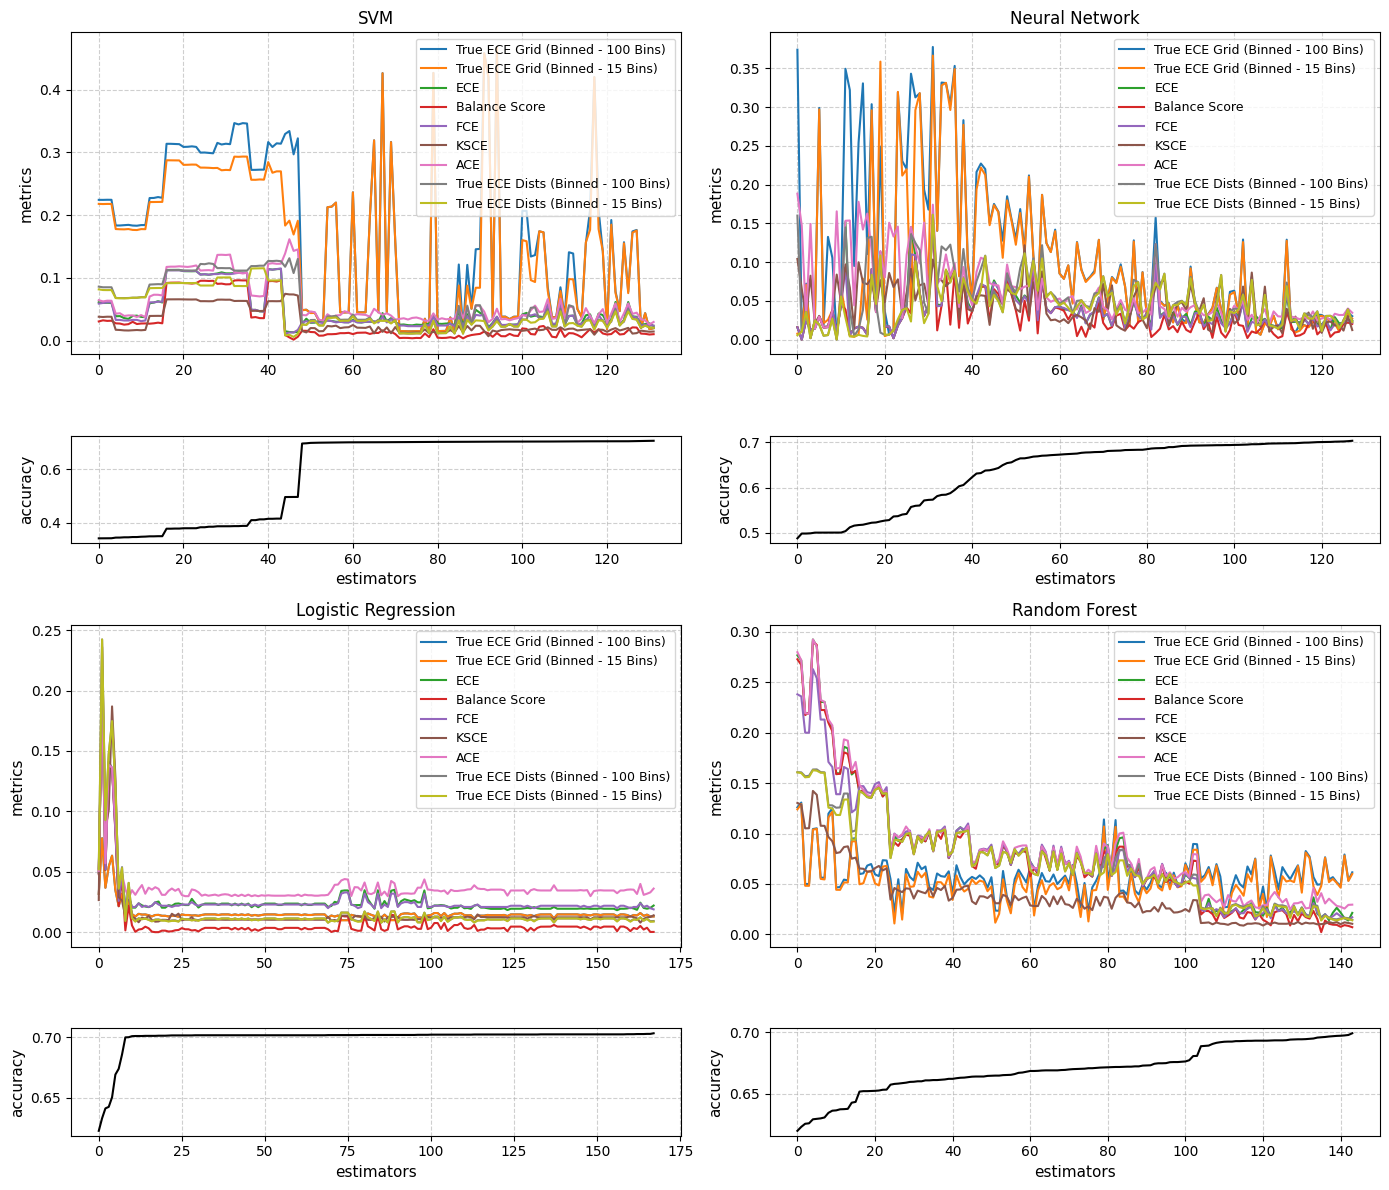

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(14, 12))
gs = GridSpec(4, 2, height_ratios=[3, 1, 3, 1], figure=fig)

for i, results in enumerate(resultss):
    col = i % 2
    base_row = 0 if i < 2 else 2

    # Plot calibration metrics
    ax = fig.add_subplot(gs[base_row, col])
    ax.set_title(models[i], fontsize=12)
    ax.set_ylabel("metrics", fontsize=11)
    ax.grid(True, linestyle='--', alpha=0.6)

    accuracies = np.array([result["Accuracy"] for result in results])
    indices = np.argsort(accuracies)

    valuess = [list(result.values()) for result in results]
    metrics = np.array(valuess).T
    x_values = range(len(results))
    metric_names = list(results[0].keys())

    for j, metric in enumerate(metrics):
        metric_name = metric_names[j]
        if metric_name not in ["TCE", "Accuracy"]:
            ax.plot(x_values, metric[indices], label=metric_name)
    ax.legend(fontsize=9)
    
    # Plot accuracy below
    ax_acc = fig.add_subplot(gs[base_row + 1, col])
    ax_acc.plot(x_values, accuracies[indices], color='black')
    ax_acc.set_xlabel("estimators", fontsize=11)
    ax_acc.set_ylabel("accuracy", fontsize=11)
    ax_acc.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout() 
#plt.savefig("./plots/grid_search_summary_gummy_worm")
plt.savefig("./plots/grid_search_summary_exclamation_mark")
plt.show()
